In [1]:
!pip install qiskit
!pip install qiskit-aer
!pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=31ae521852c33d0ee27b97564447eb6d90b4ec7b698c0639681fcc9050d16321
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def clouds(num_points=100):
  centers = [(1,1), (-1,-1)]
  spreads = [0.5, 0.7]
  labels = [-1, 1]

  x = []
  y = []
  for center, spread, label in zip(centers, spreads, labels):
    x += np.random.multivariate_normal(center, spread * np.identity(2), num_points).tolist()
    y += [label] * num_points

  return x, y

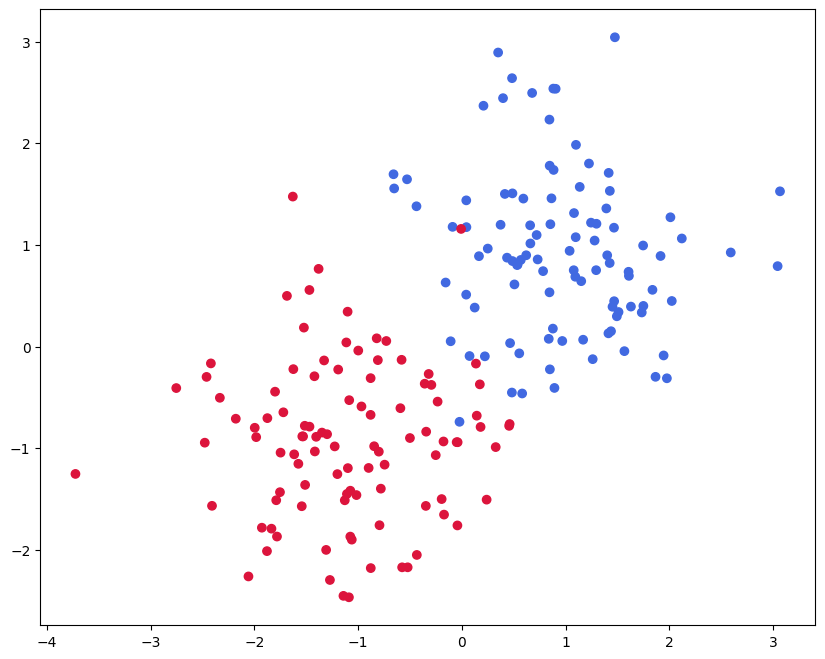

In [3]:
x, y = clouds(100)

colors = ["crimson" if label == 1 else "royalblue" for label in y]
plt.figure(figsize=(10,8))
plt.scatter(np.array(x)[:,0], np.array(x)[:,1], color=colors);

In [4]:
# Defining the loss function

def loss(support_vector, x, y, penalty=1e5):
  w = support_vector[1:]
  b = support_vector[0]

  norm = np.linalg.norm(w) **2
  constraint = sum(max(0, 1 - y[i] * (np.dot(w, x[i]) - b)) for i in range(len(y)))

  return norm + penalty * constraint

In [5]:
from scipy.optimize import minimize

# Initialize the optimizer with L-BFGS-B method
result = minimize(
    lambda sv: loss(sv, x, y),  # The function to minimize
    x0=np.random.random(3),     # Initial guess
    method='L-BFGS-B',          # Specify the optimization method
    bounds=None                 # You can add bounds if needed, e.g. [(0, 1), (0, 1), (0, 1)]
)

support_vector = result.x

In [6]:
# Classify our new points
def classify(point, support_vector):
  w = support_vector[1:]
  b = support_vector[0]
  return np.sign(np.dot(w, point) + b)

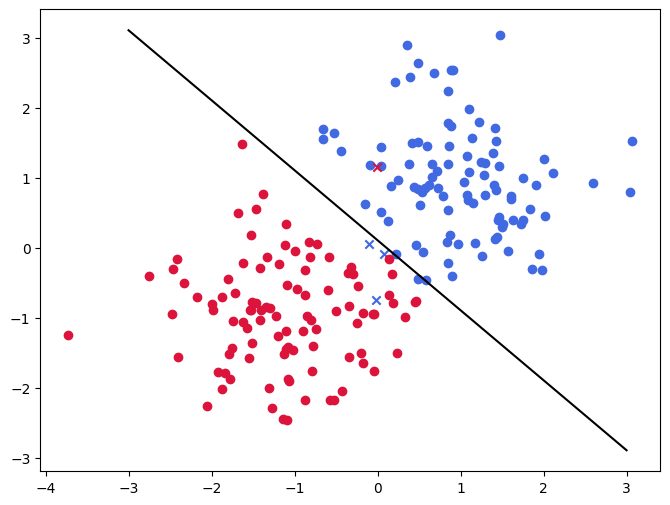

In [7]:
# Predict
predicted = [classify(point, support_vector) for point in x]
colors = ["crimson" if label == 1 else "royalblue" for label in y]
markers = ["o" if label == predicted_label else "x" for label, predicted_label in zip(y, predicted)]
plt.figure(figsize=(8,6))
for point, marker, color in zip(x, markers, colors):
  plt.scatter(point[0], point[1], marker=marker, color=color)

b, w = support_vector[0], support_vector[1:]
x1 = np.linspace(-3,3, num=100)
x2 = -1 / w[1] * (w[1] * x1 + b)
plt.plot(x1, x2, "k-");

In [8]:
# You can just use the sklearn package
from sklearn.svm import SVC

model = SVC()
model.fit(x, y)

sk_predict = model.predict(x)

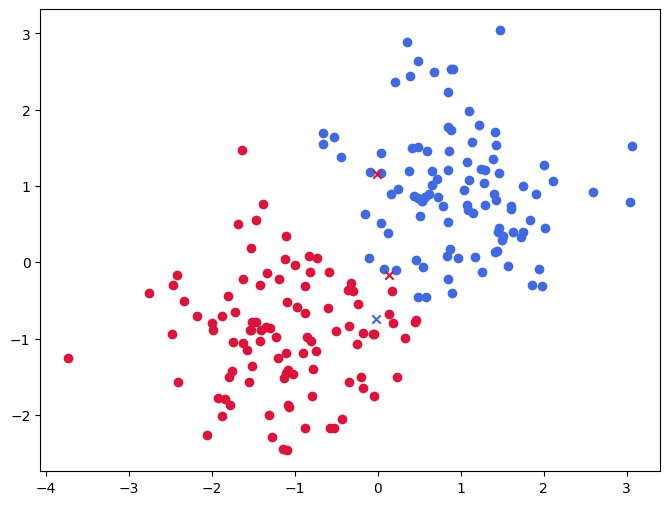

In [9]:
# Plot the results
colors = ["crimson" if label == 1 else "royalblue" for label in y]
markers = ["o" if label == predicted_label else "x" for label, predicted_label in zip(y, sk_predict)]
plt.figure(figsize=(8,6))
for point, marker, color in zip(x, markers, colors):
  plt.scatter(point[0], point[1], marker=marker, color=color)

In [10]:
# Non-linear data
def circle():
  num_points = 250
  points = 1 -2 * np.random.random((num_points, 2))

  radius = 0.6
  labels = [1 if np.linalg.norm(point) > radius else -1 for point in points]

  return points, labels

Text(0, 0.5, '')

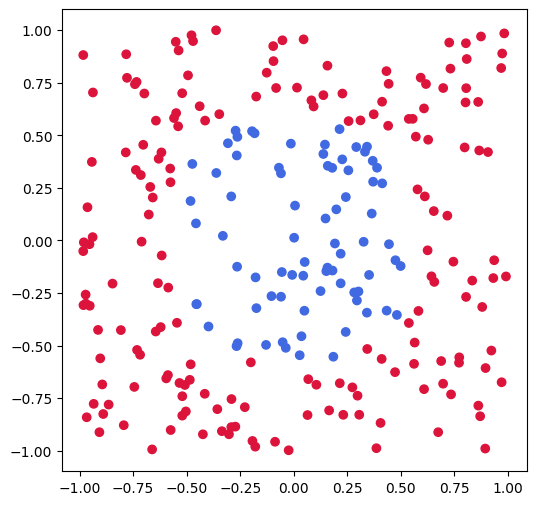

In [11]:
# Plot the results
points, labels = circle()
colors = ["crimson" if label == 1 else "royalblue" for label in labels]
plt.figure(figsize=(6,6))
plt.scatter(points[:,0], points[:,1], color=colors)
plt.xlabel("")
plt.ylabel("")

In [12]:
# Embed data in higher dimensional space, maybe it's linearly separable there?
def feature_map(x):
  return np.array([x[0], x[1], x[0] ** 2 + x[1] ** 2])

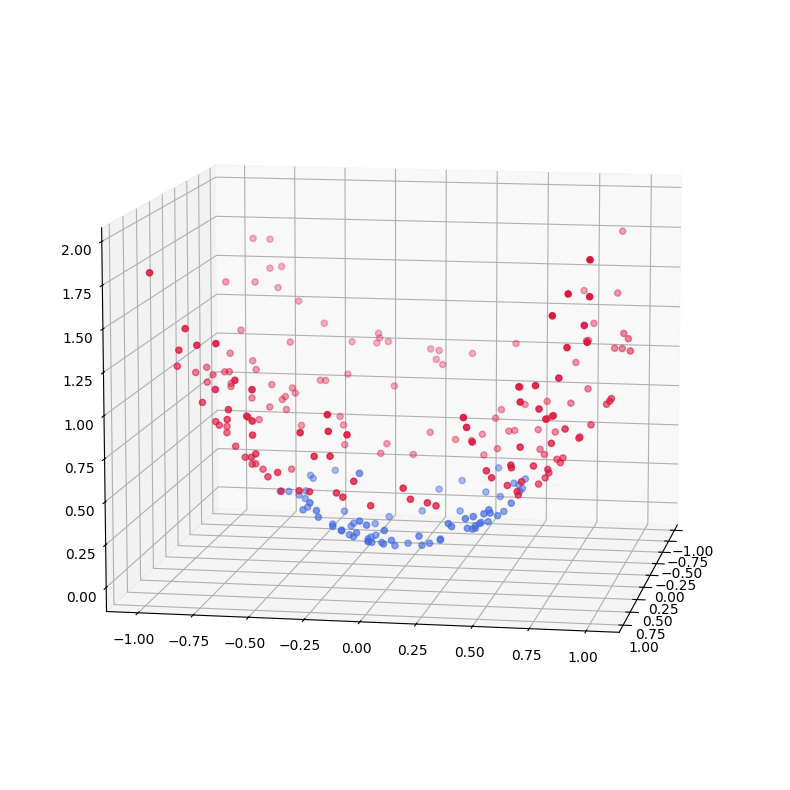

In [13]:
# Plot the new data
embedded_points = np.array([feature_map(point) for point in points])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(embedded_points[:, 0], embedded_points[:, 1], embedded_points[:, 2], color=colors)
ax.view_init(10, 10)

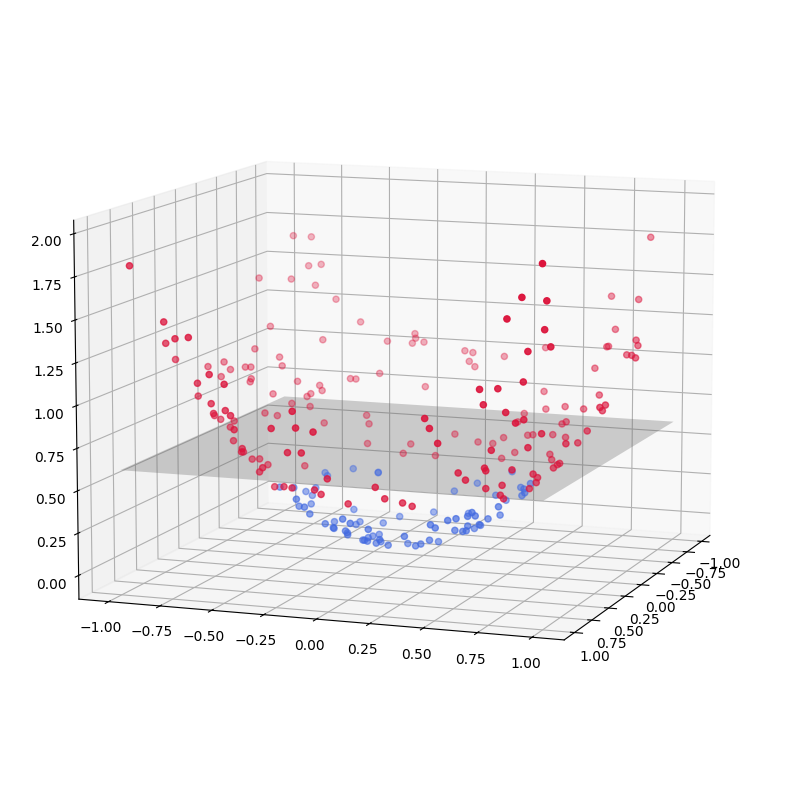

In [14]:
# Plot the new data with hyperplane
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(embedded_points[:, 0], embedded_points[:, 1], embedded_points[:, 2], color=colors)

x, y = np.meshgrid([1, -1], [1, -1])
ax.plot_surface(x, y, 0.6 * np.ones_like(x), alpha=0.3, color="grey")

ax.view_init(10, 20)

Text(0, 0.5, '')

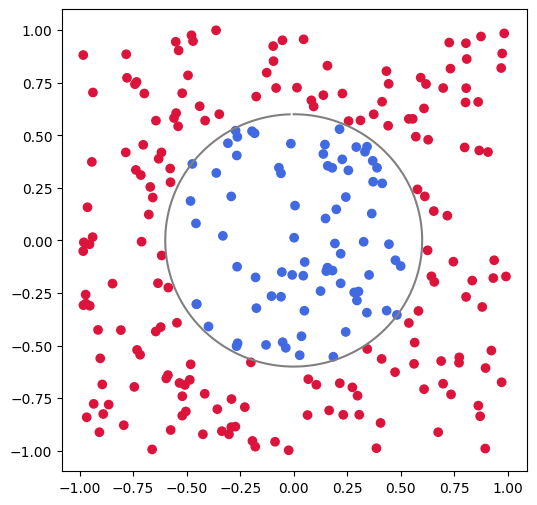

In [15]:
# Reduce this back from 3d to 2d and we will get a circle
plt.figure(figsize=(6,6))
plt.scatter(embedded_points[:, 0], embedded_points[:, 1], color=colors)

angels = np.linspace(0, 2 * np.pi, num=200, endpoint=False)
x = 0.6 * np.sin(angels)
y = 0.6 * np.cos(angels)
plt.plot(x, y, color="grey")

plt.xlabel("")
plt.ylabel("")

/usr/local/lib/python3.11/dist-packages/qiskit/visualization/circuit/matplotlib.py:269: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: /usr/local/lib/python3.11/dist-packages/qiskit/visualization/circuit/styles/iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


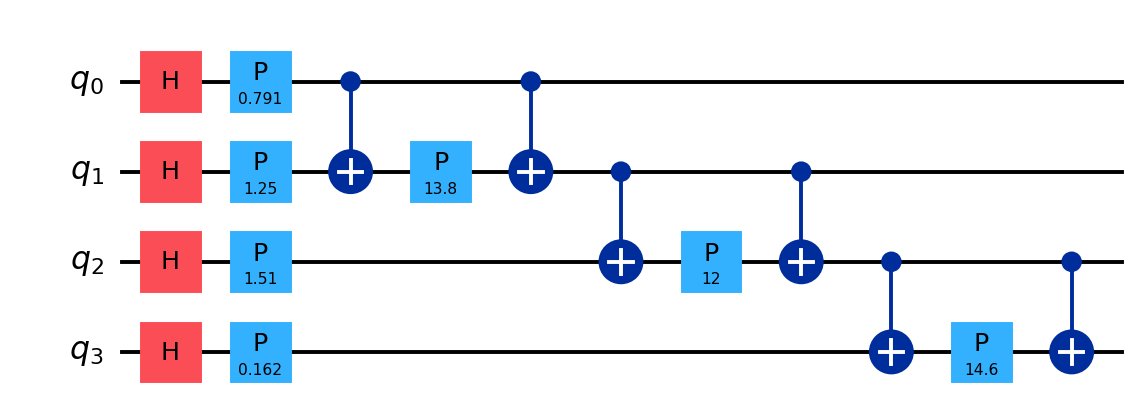

In [16]:
from qiskit.circuit.library import ZZFeatureMap

num_qbits = 4
x = np.random.random(num_qbits)

data = ZZFeatureMap(feature_dimension=num_qbits, reps=1, entanglement="linear")
data.assign_parameters(x, inplace=True)
data.decompose().draw("mpl", style="iqx", scale=1.4)


/usr/local/lib/python3.11/dist-packages/qiskit/visualization/circuit/matplotlib.py:269: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: /usr/local/lib/python3.11/dist-packages/qiskit/visualization/circuit/styles/iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


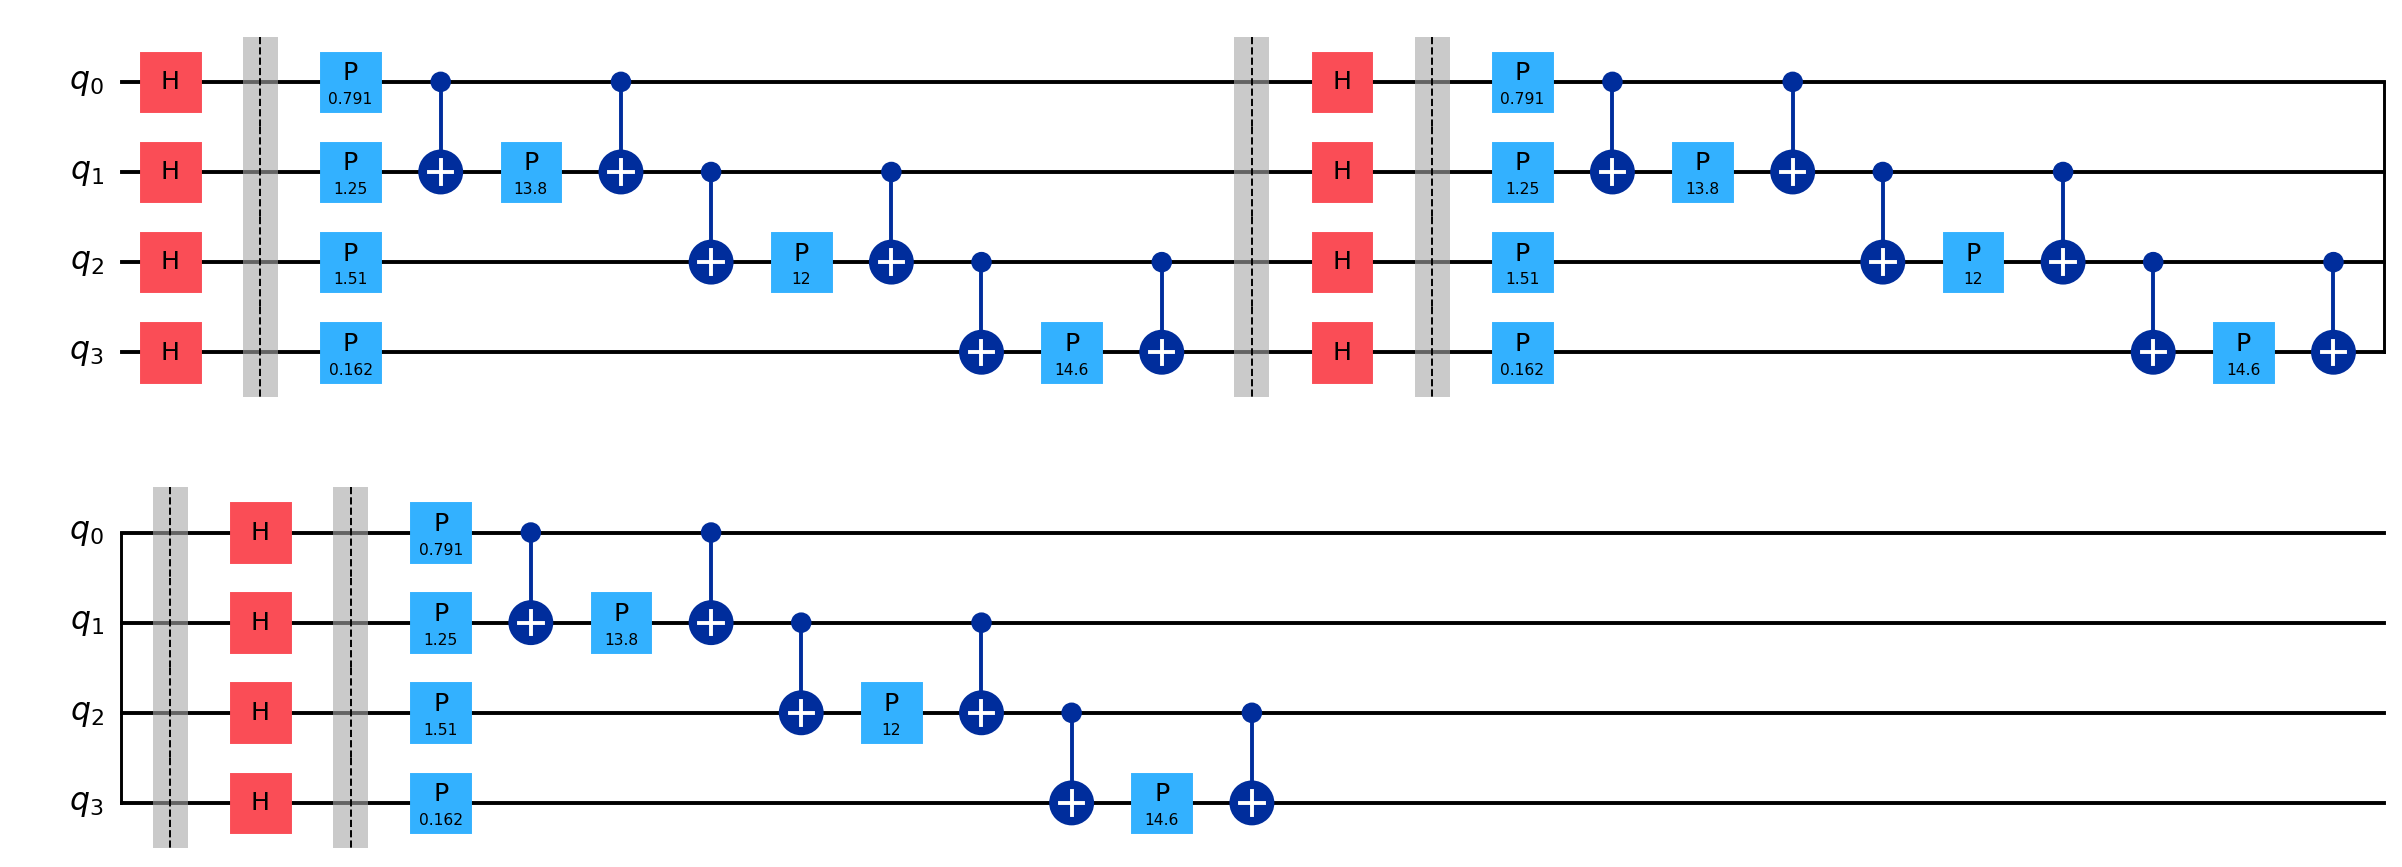

In [19]:
data = ZZFeatureMap(feature_dimension=num_qbits, reps=3, entanglement="linear", insert_barriers=True)
data.assign_parameters(x, inplace=True)
data.decompose().draw("mpl", style="iqx", scale=1.4)

# Quantum Kernel Evaluation

This code implements a quantum kernel using Qiskit's `ZZFeatureMap`. The kernel evaluates the similarity between two data points in a quantum feature space.

## How it works

1. Creates a quantum circuit using `ZZFeatureMap` with 2 dimensions
2. Encodes the first point (`x_i`) into the circuit
3. Applies the inverse feature map for the second point (`x_j`)
4. Measures the circuit multiple times (`shots=1024`)
5. Returns the probability of measuring all zeros

## Technical Details

- The `ZZFeatureMap` requires exactly 2 parameters (`dimension=2`)
- Single values are automatically converted to 2D vectors
- Uses `AerSimulator` for quantum circuit simulation
- Returns a value between 0 and 1 representing similarity

## Example Usage

```python
x = np.array([1.0, 2.0, 3.0, 4.0])
result = evaluate_kernel(x[2], x[3])  # Compares points 3.0 and 4.0
```

## Notes

- Higher return values indicate greater similarity between points
- The kernel is symmetric: `evaluate_kernel(x_i, x_j) == evaluate_kernel(x_j, x_i)`
- The result is probabilistic due to quantum measurement

In [17]:
# Building a quantum kernel
from qiskit import transpile, QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.circuit.library import ZZFeatureMap
import numpy as np

backend = AerSimulator()
shots = 1024

dimension = 2
feature_map = ZZFeatureMap(dimension, reps=1)

def evaluate_kernel(x_i, x_j):
    # Skapa en array med två element för varje punkt
    # Om vi får ett enskilt värde, upprepar vi det
    if not isinstance(x_i, (list, np.ndarray)):
        x_i = np.array([x_i, x_i])
    if not isinstance(x_j, (list, np.ndarray)):
        x_j = np.array([x_j, x_j])

    # Se till att vi har exakt 2 element
    if len(x_i) != 2:
        x_i = np.array([x_i[0], x_i[0]])
    if len(x_j) != 2:
        x_j = np.array([x_j[0], x_j[0]])

    circuit = QuantumCircuit(dimension)
    circuit.compose(feature_map.assign_parameters(x_i), inplace=True)
    circuit.compose(feature_map.assign_parameters(x_j).inverse(), inplace=True)
    circuit.measure_all()

    transpiled = transpile(circuit, backend)
    counts = backend.run(transpiled, shots=shots).result().get_counts()

    return counts.get("0" * dimension, 0) / shots

In [18]:
evaluate_kernel(x[2], x[3])

0.3212890625

#06:29 Quantum SVM